# Import

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

from sklearn.preprocessing import LabelEncoder

from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import umap

from sklearn.mixture import GaussianMixture
import pickle

from sklearn.neighbors import KernelDensity

# TASK 3 - GMM

## Model selection

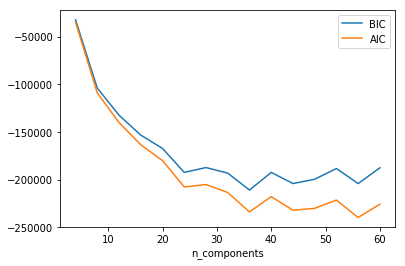

In [15]:
# fit the models
n_components = [4,8,12,16,20,24,28,32,36,40,44,48,52,56,60]
gmms = [GaussianMixture(n_components=k).fit(sTrain) for k in n_components]

# plot the bics and aics
bics = [gmm.bic(sTrain) for gmm in gmms]
aics = [gmm.aic(sTrain) for gmm in gmms]

plt.plot(n_components, bics, label = 'BIC')
plt.plot(n_components, aics, label = 'AIC')
plt.xlabel('n_components')
plt.legend()
plt.show()


## Fit a GMM with 8 and 36 components on diseased and control groups

In [24]:
G8s = {"control": None,"diseased": None}
G36s = {"control": None ,"diseased": None}

for g in ["control","diseased"]:
    group = df[df.group == g]
    group_cells = group[group.columns.difference(["id","group"])]

    G8s[g] = GaussianMixture(n_components=8).fit(X = group_cells, y = None)
    G36s[g] = GaussianMixture(n_components=36).fit(X = group_cells, y = None)


### Save the models to a file

In [19]:
def save_model(model, filename):
        pickle.dump(model, open(filename, 'wb'))

In [25]:
for key in G8s:
    model = G8s[key]
    filename = 'G8_{0}.sav'.format(key)
    save_model(model,filename)

for key in G36s:
    model = G36s[key]
    filename = 'G36_{0}.sav'.format(key)
    save_model(model,filename)

### Load the models from file

In [8]:
def load_model(filename):
    return pickle.load(open(filename, 'rb'))

In [9]:
G8s_ = {"control": load_model('G8_control.sav'),"diseased": load_model('G8_diseased.sav')}
G36s_ = {"control": load_model('G36_control.sav') ,"diseased": load_model('G36_diseased.sav')}

## Generate data from the GMMs 

In [10]:
def generate_patients(gmm, sample_size, nr_patients):
    """
    PARAMETERS:
    ----------
    gmm (fitted GaussianMixture object): 
    sample_size (int): number of cells per patient
    nr_patients (int): number of patients to generate
    
    RETURNS:
    -------
    patients (array): list of patients, each patient with `sample_size` cells.
    """
    patients = np.array([gmm.sample(sample_size)[0] for i in range(nr_patients)])
    return patients
        

In [7]:
sample_size = 20000 # this represents one patient
nr_patients = 20

G8_patients = {"control": generate_patients(G8s["control"],sample_size, nr_patients),
                  "diseased":  generate_patients(G8s["diseased"],sample_size, nr_patients)}

G36_patients = {"control":  generate_patients(G36s["control"],sample_size, nr_patients), 
                   "diseased": generate_patients(G36s["diseased"],sample_size, nr_patients)}




## Train a discriminator (real vs augmented data)

### Candidates
- Nearest Neighbour
- SVM (Linear, RBF)
- Gaussian process
- Neural Net
- Naive Bayes
- QDA

### Prepare data for Classification

In [8]:
X_real = df[df.columns.difference(["id","group"])]
X_8pc = G8_patients["control"].reshape((400000, 12))
X_8pd = G8_patients["diseased"].reshape((400000, 12))
X_36pc = G36_patients["control"].reshape((400000, 12))
X_36pd = G36_patients["diseased"].reshape((400000, 12))

# map real to 1 and augmented to 0
y_real = np.ones(df.group.size)
y_8pc = np.zeros(X_8pc.shape[0])
y_8pd = np.zeros(X_8pd.shape[0])
y_36pc = np.zeros(X_36pc.shape[0])
y_36pd = np.zeros(X_36pd.shape[0])

In [10]:
X_8 = np.concatenate((X_real, X_8pc, X_8pd), axis = 0)
X_36 = np.concatenate((X_real, X_36pc, X_36pd), axis = 0)
y_8 = np.concatenate((y_real, y_8pc, y_8pd), axis = 0)
y_36 = np.concatenate((y_real, y_36pc, y_36pd), axis = 0)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [12]:
X8_train, X8_test, y8_train, y8_test = train_test_split(X_8, y_8, test_size=.4, random_state=42)
X36_train, X36_test, y36_train, y36_test = train_test_split(X_36, y_36, test_size=.4, random_state=42)

In [13]:
clf8 = KNeighborsClassifier(3)
clf8.fit(X8_train, y8_train)
print clf8.score(X8_test,y8_test)

0.83935625


In [14]:
clf36 = KNeighborsClassifier(3)
clf36.fit(X36_train, y36_train)
print clf36.score(X36_test,y36_test)

0.7722546875


### Notes
- We can see that GMM with 36 components better confuses the classifier
- However, a simple classifier like KNeighborsClassifier can still distinguish between real and augmented data better than random